In [1]:
%load_ext autoreload
%autoreload 2
 
#%matplotlib inline

In [2]:
import sys
sys.path.append('../../../src/')

import os
from typing import Dict
from os import PathLike
from pathlib import Path

from aind_vr_foraging_analysis import utils
from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np
import datetime

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle


colors = sns.color_palette()
odor_list_color = [colors[7], colors[0], colors[2], colors[4]]

pdf_path = r'/Volumes\scratch\vr-foraging\sessions'
base_path = r'/Volumes/scratch/vr-foraging/data/'
foraging_figures = r'/Users/nehal.ajmal/Documents/aindproject/results'

from scipy.optimize import curve_fit


# **One session exploration**

In [3]:
# date = datetime.date.today()
# date_string = "7/15/2024"
# date = datetime.datetime.strptime(date_string, "%m/%d/%Y").date()
# mouse = '717716'

In [4]:
session_path= r'/Volumes/scratch/vr-foraging/data/717716/717716_20240715T094102'
mouse = '717716'
session = '717716_20240716T092600'

In [5]:
# session_found = False

# directory = os.path.join(base_path, mouse)
# files = os.listdir(os.path.join(base_path, mouse))

# sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)

# # All this segment is to find the correct session without having the specific path
# for file_name in sorted_files:
    
#     if session_found == True:
#         break
    
#     print(file_name)
#     # Find specific session sorted by date
#     session = file_name.split('_')[1][:8]
#     if datetime.datetime.strptime(session, "%Y%m%d").date() != date:
#         continue
#     else:
#         print('correct date found')
#         session_found = True

# #Recover data streams
# session_path = os.path.join(base_path, mouse, file_name)

In [6]:
session_path = Path(session_path)
data = parse.load_session_data(session_path)

#Parse data into a dataframe with the main features
reward_sites, active_site, config = parse.parse_dataframe(data)
# -- At this step you can save the data into a csv file

# Expand with extra columns
reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites

In [7]:
active_site

,label,start_position,length
Seconds,,,
9.068443e+06,InterPatch,9.014054,143.830906
9.068451e+06,InterSite,152.844961,22.401221
9.068451e+06,RewardSite,175.246182,50.000000
9.068453e+06,InterSite,225.246182,61.090511
9.068455e+06,InterPatch,286.603210,59.309982
...,...,...,...
9.070545e+06,InterPatch,26305.599609,219.892095
9.070555e+06,InterSite,26525.491704,23.934607
9.070556e+06,RewardSite,26549.426311,50.000000


In [8]:
reward_sites.groupby('odor_label')['odor_label'].count()

odor_label
NULL      88
ODOR_A     8
Name: odor_label, dtype: int64

In [9]:
# Load the encoder data separately
stream_data = parse.ContinuousData(data)
encoder_data = stream_data.encoder_data

# ## Remove the last segment of the session when the mouse is not engaged
# last_engaged_patch = reward_sites['active_patch'][reward_sites['skipped_count'] >= 10].min()
# if pd.isna(last_engaged_patch):
#     last_engaged_patch = reward_sites['active_patch'].max()
# reward_sites = reward_sites.loc[reward_sites['active_patch'] <= last_engaged_patch]

# Recover color palette
color_dict_label = {}
dict_odor = {}
list_patches = parse.TaskSchemaProperties(data).patches
for i, patches in enumerate(list_patches):
    color_dict_label[patches['label']] = odor_list_color[i]
    dict_odor[i] = patches['label']

In [10]:
# Summary of different relevants aspects -------------------------------------------------

unrewarded_stops = reward_sites.loc[reward_sites.reward_delivered==0]['collected'].count()
rewarded_stops = reward_sites.loc[reward_sites.reward_delivered==1]['collected'].count()
water_collected = reward_sites.loc[(reward_sites['reward_delivered']==1)]['collected'].sum()
total_stops = reward_sites.loc[(reward_sites['has_choice']==True)]['reward_available'].count()

stopped_df = reward_sites.loc[(reward_sites['has_choice']==True)].groupby(['collected','odor_label'])[['reward_delivered']].sum().reset_index()

# Rewarded stops / total available rewarded stops
optimality = rewarded_stops / reward_sites[reward_sites.reward_available != 0]['reward_delivered'].count()

# Rewarded stops / Stops
efficiency = rewarded_stops / reward_sites.reward_delivered.sum()

print('Total sites: ' ,len(reward_sites), ' | ', 'Total rewarded stops: ',rewarded_stops, '(',  np.round((rewarded_stops/total_stops)*100,2),'%) | ', 
    'Total unrewarded stops: ',unrewarded_stops,'(',  np.round((unrewarded_stops/total_stops)*100,2),'%) | ','Water consumed: ', water_collected, 'ul')

if 'startPosition' in active_site.columns:
    stop_duration = np.round(active_site.startPosition.max()/100,2)
else:
    stop_duration = np.round(active_site.start_position.max()/100,2)
print('Total travelled m: ', np.round(active_site.start_position.max()/100,2))

for odor_label in reward_sites.odor_label.unique():
    values = reward_sites.loc[(reward_sites['odor_label']==odor_label)&(reward_sites['reward_delivered']==1)]['collected'].sum()
    print(f'{odor_label} {values} ul')

#get duration of each session from active site index
duration = active_site.index[-1] - active_site.index[0]
print(duration)

Total sites:  96  |  Total rewarded stops:  0 ( nan %) |  Total unrewarded stops:  96 ( inf %) |  Water consumed:  0.0 ul
Total travelled m:  266.59
NULL 0.0 ul
ODOR_A 0.0 ul
2122.374015999958


### Segments of the session

Sequential data showing different elements of the behavior all together. 

In [11]:
label_dict = {**{
    "InterSite": '#808080',
    "InterPatch": '#b3b3b3'}, 
              **color_dict_label}

In [12]:
active_site = AddExtraColumns(reward_sites, active_site, run_on_init=True).total_epochs

### Segments of the session in patches

Same as above but plotting only one patch at a time

In [13]:
def update_plot(x_start):
    zero_index = active_site.index[0]

    start = active_site.loc[active_site['active_patch']==x_start].index[0] - zero_index
    stop = active_site.loc[active_site['active_patch']==x_start+1].index[1] - zero_index
    
    fig, axs = plt.subplots(1,1, figsize=(20,4))
    plt.title('Patch: ' + str(x_start))
    _legend = {}
    for idx, site in enumerate(active_site.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "RewardSite":
            site_label = site[1]['odor_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (active_site.index[idx] - zero_index, -2), active_site.index[idx+1] - active_site.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        _legend[site_label] = p
        axs.add_patch(p)

    s, lw = 400, 2
    # Plotting raster
    y_idx = -0.4
    _legend["Choice Tone"] = axs.scatter(stream_data.choice_feedback.index - zero_index+0.2,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='darkblue',
            label="Choice Tone")
    y_idx += 1
    _legend["Lick"] = axs.scatter(stream_data.lick_onset.index - zero_index,
            stream_data.lick_onset.index * 0 + y_idx,
            marker="|", s=s, lw=lw, c='k',
            label="Lick")
    _legend["Reward"] = axs.scatter(stream_data.valve_output_pulse.index - zero_index,
            stream_data.valve_output_pulse.index*0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")
    # _legend["Waits"] = axs.scatter(stream_data.succesfull_wait.index - zero_index,
    #     succesfull_wait.index*0 + 1.2,
    #     marker=".", s=s, lw=lw, c='green',
    #     label="Reward")
    
    # _legend["Odor_on"] = axs.scatter(odor_on - zero_index,
    #     odor_on*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='pink',
    #     label="ON")
    
    # _legend["Odor_off"] = axs.scatter(odor_off - zero_index,
    #     odor_off*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='purple',
    #     label="ON")
    
    y_idx += 1

    #ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
    axs.set_yticklabels([])
    axs.set_xlabel("Time(s)")
    axs.set_ylim(bottom=-1, top = 3)
    axs.grid(False)
    plt.gca().yaxis.set_visible(False)

    ax2 = axs.twinx()
    _legend["Velocity"] = ax2.plot(stream_data.encoder_data.index - zero_index, stream_data.encoder_data.filtered_velocity, c="k", label="Encoder", alpha = 0.8)[0]
    try:
        v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")
    axs.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

    # axs[0].stairs(software_events.streams.RewardAvailableInPatch.data["data"].values[:-1],
    #           software_events.streams.RewardAvailableInPatch.data["data"].index.values -  zero_index,
    #           lw = 3, color = 'k', fill=0)
    
    axs.set_xlabel("Time(s)")
    axs.grid(False)
    axs.set_ylim(bottom=-1, top = 4)
    axs.set_yticks([0,3])
    axs.yaxis.tick_right()
    axs.set_xlim([start, stop + 10])

# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 1

def on_right_button_clicked(button):
    x_start_widget.value += 1

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

Output()

### Segments of the session with sniff data

Explore data but having the sniff data on top (it takes longer to plot)

In [22]:
def update_plot(x_start):
    zero_index = active_site.index[0]

    fig, axs = plt.subplots(2,1, figsize=(20,8), gridspec_kw={'height_ratios': [2, 2]}, sharex=True)

    # sites_test = sites.loc[(sites.index > (zero_index + x_start))&(sites.index < (zero_index + x_start + 50))]   
    _legend = {}
    for idx, site in enumerate(active_site.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "RewardSite":
            site_label = site[1]['odor_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (active_site.index[idx] - zero_index, -2), active_site.index[idx+1] - active_site.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        
        _legend[site_label] = p
        axs[0].add_patch(p)
        
        q = Rectangle(
            (active_site.index[idx] - zero_index, -2), active_site.index[idx+1] - active_site.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        _legend[site_label] = q
        axs[1].add_patch(q)
        # axs[1].add_patch(p)
        
    s, lw = 400, 2
    # Plotting raster
    y_idx = -0.4
    _legend["Choice Tone"] = axs[1].scatter(stream_data.choice_feedback.index - zero_index+0.2,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='darkblue',
            label="Choice Tone")
    y_idx += 1
    _legend["Lick"] = axs[1].scatter(stream_data.lick_onset.index - zero_index,
            stream_data.lick_onset.index * 0 + y_idx,
            marker="|", s=s, lw=lw, c='k',
            label="Lick")
    _legend["Reward"] = axs[1].scatter(stream_data.give_reward.index - zero_index,
            stream_data.give_reward.index*0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")
    # _legend["Waits"] = axs[1].scatter(stream_data.successfull_wait.index - zero_index,
    #     stream_data.successfull_wait.index*0 + 1.2,
    #     marker=".", s=s, lw=lw, c='green',
    #     label="Reward")
    # _legend["Odor_on"] = axs.scatter(odor_on - zero_index,
    #     odor_on*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='pink',
    #     label="ON")
    
    # _legend["Odor_off"] = axs.scatter(odor_off - zero_index,
    #     odor_off*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='purple',
    #     label="ON")
    
    y_idx += 1

    #ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
    axs[1].set_yticklabels([])
    axs[1].set_xlabel("Time(s)")
    axs[1].set_ylim(bottom=-1, top = 3)
    axs[1].grid(False)

    ax2 = axs[1].twinx()
    _legend["Velocity"] = ax2.plot(encoder_data.index - zero_index, encoder_data.filtered_velocity, c="k", label="Encoder", alpha = 0.8)[0]
    try:
        v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")

    ax3 = axs[0].twinx()
    _legend["Breathing"] = ax3.plot(stream_data.breathing.index - zero_index, stream_data.breathing.values, c="black", label="Breathing", alpha = 0.8)[0]
    # _legend["Breathing"] = ax3.plot(filtered_breathing.index - zero_index, filtered_breathing['data'].values, c="black", label="Breathing", alpha = 0.8)[0]

    ax3.grid(False)
    ax3.set_ylim(stream_data.breathing.mean()[0]+100, stream_data.breathing.mean()[0]-100)
    ax3.set_ylabel("Breathing (au)")
    ax3.set_ylim((1500, 3000))
    axs[0].legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.08, 0.1), loc='center left', borderaxespad=0.)

    # axs[0].stairs(software_events.streams.RewardAvailableInPatch.data["data"].values[:-1],
    #           software_events.streams.RewardAvailableInPatch.data["data"].index.values -  zero_index,
    #           lw = 3, color = 'k', fill=0)
    
    for i in [0,1]:
        axs[i].set_xlabel("Time(s)")
        axs[i].grid(False)
        axs[i].set_ylim(bottom=-1, top = 4)
        axs[i].set_yticks([])
        axs[i].yaxis.tick_right()
        axs[i].set_xlim([x_start, x_start + 100])
        
    # plt.savefig(foraging_figures + f"\{x_start_widget.value}_time_detrended.svg", bbox_inches='tight', pad_inches=0.1, transparent=True)
    
# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 10

def on_right_button_clicked(button):
    x_start_widget.value += 10

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

Output()

### **Detailed plots**
With the dataframe reward_sites you can explore different aspects of the behavior. You can for instance use it to align velocity traces and look at how they might be different for different odors. 

In [15]:
reward_sites.columns

Index(['label', 'start_position', 'length', 'active_patch', 'visit_number',
       'has_choice', 'reward_delivered', 'stop_cue', 'succesful_wait',
       'water_onset', 'odor_label', 'cumulative_rewards', 'reward_amount',
       'reward_available', 'odor_sites', 'collected', 'depleted', 'last_visit',
       'last_site', 'skipped_count', 'consecutive_rewards',
       'cumulative_failures', 'consecutive_failures',
       'after_choice_cumulative_rewards', 'total_sites', 'previous_interpatch',
       'previous_intersite', 'same_patch'],
      dtype='object')

In [16]:
trial_summary = plotting.trial_collection(reward_sites[[ 'visit_number', 'odor_label','odor_sites']], encoder_data, mouse, session, window=(-2,4))

In [17]:
trial_summary.loc[(trial_summary.odor_label == 'NULL')].odor_sites.unique()


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       28., 29., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44., 45., 46., 48., 49., 50., 51., 52., 53., 55., 56., 57.,
       58., 59., 60., 61., 62., 64., 65., 66., 67., 68., 69., 70., 71.,
       72., 73., 74., 75., 76., 77., 78., 79., 81., 82., 83., 84., 85.,
       86., 87., 88., 89., 90., 91., 92., 93., 94., 95.])

In [18]:
trial_summary.times.unique()

array([-1.999, -1.995, -1.991, ...,  3.995,  3.999,  4.   ])

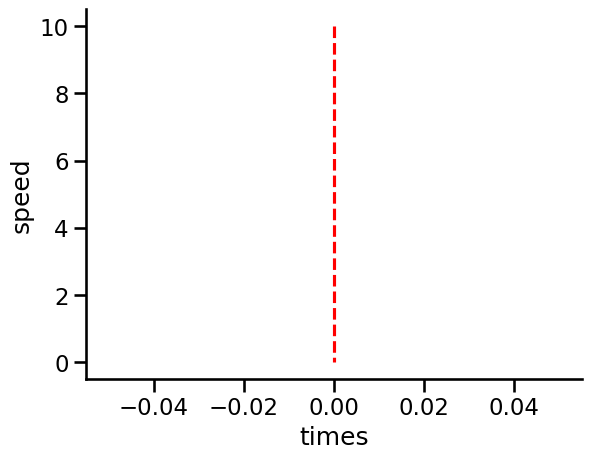

In [19]:
first_site = trial_summary.loc[(trial_summary.odor_label == 'ODOR_A')&(trial_summary.odor_sites == 14)] 
sns.lineplot(data=first_site, x='times', y='speed')
plt.vlines(0, 10, 0, linestyles='dashed', colors='r')
sns.despine()


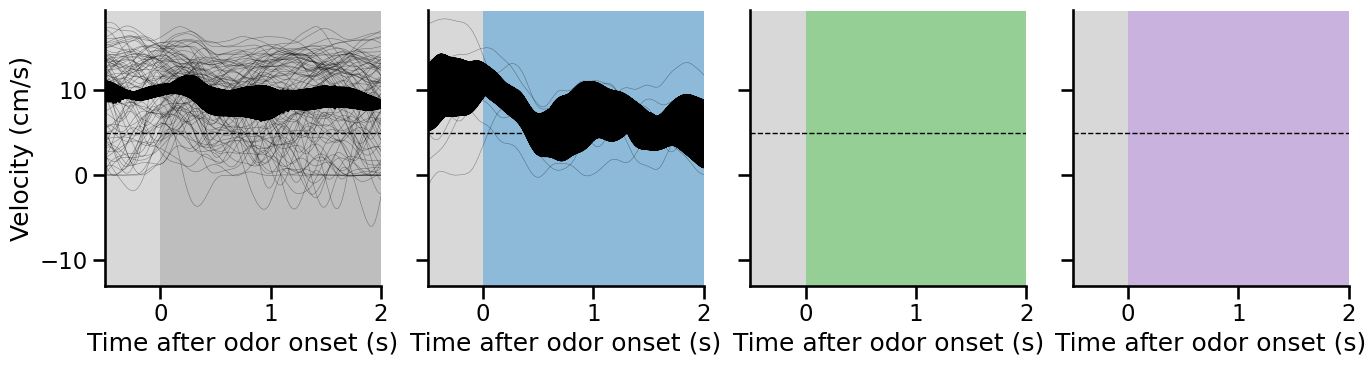

In [20]:
plotting.velocity_traces_odor_entry(trial_summary, max_range=max(trial_summary.speed.values), color_dict_label=color_dict_label, mean=True, save=False)

In [21]:
trial_summary = plotting.trial_collection(reward_sites[['has_choice', 'visit_number', 'odor_label', 'odor_sites']], encoder_data, mouse, session, window=(-1,3), aligned='odor_onset')
plotting.velocity_traces_odor_entry(trial_summary, max_range=max(trial_summary.speed.values), color_dict_label=color_dict_label, mean=False, save=False)

KeyError: 'odor_onset'

In [ ]:
reward_sites.columns

Index(['label', 'start_position', 'length', 'active_patch', 'visit_number',
       'has_choice', 'reward_delivered', 'stop_cue', 'succesful_wait',
       'water_onset', 'odor_label', 'cumulative_rewards', 'reward_amount',
       'reward_available', 'odor_sites', 'collected', 'depleted', 'last_visit',
       'last_site', 'skipped_count', 'consecutive_rewards',
       'cumulative_failures', 'consecutive_failures',
       'after_choice_cumulative_rewards', 'total_sites', 'previous_interpatch',
       'previous_intersite', 'same_patch'],
      dtype='object')

Look at a summary of the session plotting each patch and site and look at whether they were rewarded or not

AttributeError: 'DataFrame' object has no attribute 'reward_probability'

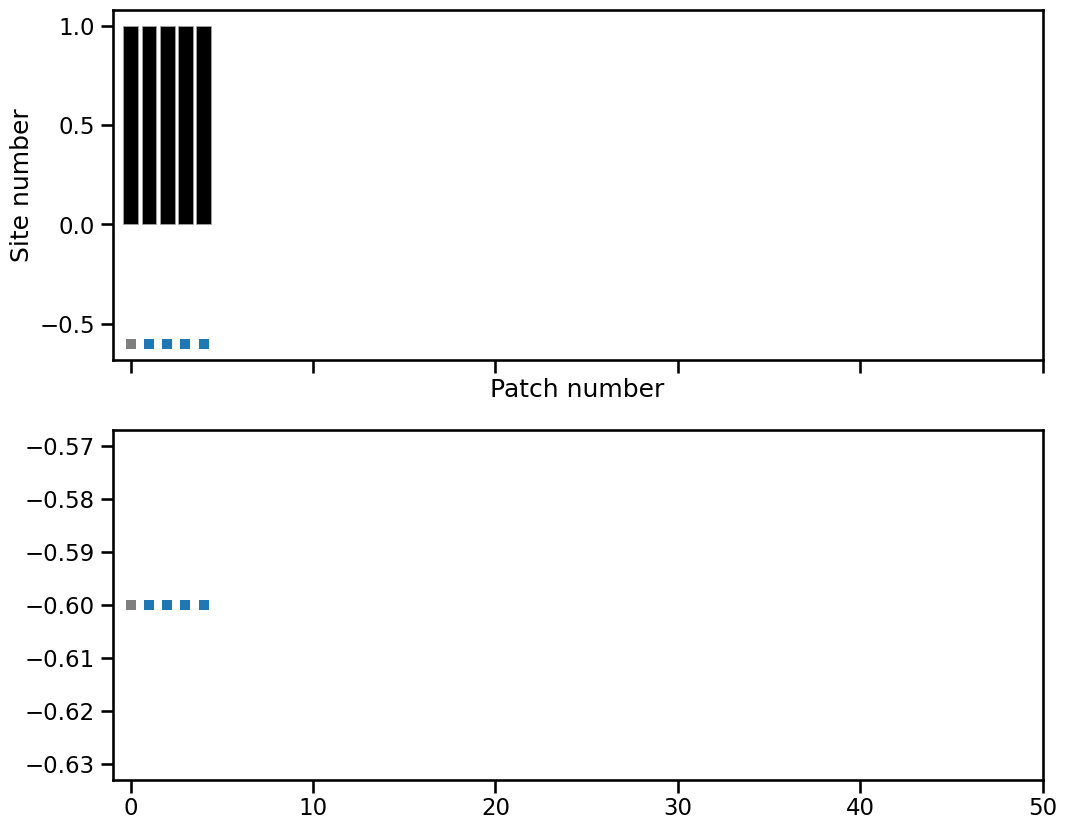

In [ ]:
summary = reward_sites.groupby(['active_patch','odor_label']).agg({'reward_delivered':'sum','visit_number':'count'})

patch_number = len(reward_sites.active_patch.unique())
number_odors = len(reward_sites['odor_label'].unique())
list_odors = []
for odor in reward_sites.odor_label.unique():
    list_odors.append(reward_sites.loc[reward_sites.odor_label == odor].active_patch.nunique())
grid = (np.array(list_odors)/patch_number)*number_odors

fig, ax = plt.subplots(2,1, figsize=(12, 10), sharex=True)

for index, row in reward_sites.iterrows():
    if row['reward_delivered'] == 1 and row['has_choice'] == True:
        color='steelblue'
    elif row['reward_delivered'] == 0 and row['has_choice'] == True:
        color='pink'
        if row['reward_available'] == 0:
            color='crimson'
    else:
        if  row['reward_available'] == 0:
            color='black'
            hatch = '/'
        else:
            color='lightgrey'
        
    ax[0].bar(int(row['active_patch']), bottom=row['visit_number'], height=1, width=0.8, color=color, edgecolor='darkgrey', linewidth=0.5)
    ax[0].set_xlim(-1,max(reward_sites.active_patch)+1)
    ax[0].set_xlim(-1,50)
    ax[0].set_xlabel('Patch number')
    ax[0].set_ylabel('Site number')
    
    if row['odor_label'] == reward_sites['odor_label'].unique()[0]:
        patch_color=odor_list_color[0]
    elif row['odor_label'] == reward_sites['odor_label'].unique()[1]:
        patch_color=odor_list_color[1]
    else:
        patch_color=odor_list_color[2]
    
    # ax1.bar(int(row['active_patch']), bottom = -1, height=0.5, width = 1, color=patch_color, edgecolor='black', linewidth=0.5)
    ax[0].scatter(row['active_patch'], -0.6, color=patch_color, marker='s', s=60, edgecolor='black', linewidth=0.0)
    ax[1].scatter(row['active_patch'], -0.6, color=patch_color, marker='s', s=60, edgecolor='black', linewidth=0.0)

odors = []
for index, odor in enumerate(reward_sites['odor_label'].unique()):
    odors.append(mpatches.Patch(color=odor_list_color[index], label=(str(odor) + '_' + str(reward_sites.loc[reward_sites.odor_label == odor].reward_probability.max()))))

label_2 = mpatches.Patch(color='steelblue', label='Harvest, rewarded')
label_3 = mpatches.Patch(color='pink', label='Harvest, no reward')
label_4 = mpatches.Patch(color='lightgrey', label='Leave')

odors.extend([label_2, label_3,label_4])
plt.legend(handles=odors, loc='lower right', bbox_to_anchor=(0.5, -0.65), fontsize=12, ncol=2)
ax[0].set_ylim(-2,max(reward_sites.visit_number)+1)

summary = reward_sites.groupby(['active_patch','odor_label']).agg({'reward_delivered':'sum','has_choice':'sum'})
summary.reset_index(inplace=True)

sns.barplot(x='active_patch', y='has_choice',data=summary, color='pink', ax=ax[1], errorbar=None)
sns.barplot(x='active_patch', y='reward_delivered', data=summary, ax=ax[1], errorbar=None)

# Specifying the number of xticks
num_ticks = 10  # Change this to the desired number of ticks
xticks = np.linspace(summary.active_patch.min(), summary.active_patch.max(), num_ticks)

# Specifying the xticks
ax[1].set_xticks(xticks)
# ax[1].set_xlim(-1,125)
ax[1].set_ylim(-1.5,reward_sites.visit_number.max()+1)
ax[1].set_ylabel('Site number')
ax[1].set_xlabel('Patch number')
sns.despine()

# fig.savefig(foraging_figures+f'/raster_plot_example_{mouse}_{date}.svg', dpi=300, bbox_inches='tight')

Explore if animals experienced a decaying curve close to the theoretical one

In [ ]:
dict_odor = {}
for i in range(len(data['config'].streams.tasklogic_input.data['environment_statistics']['patches'])):
    odor_label = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i]['label']
    rate = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i][ 'reward_specification']['reward_function']['probability']['c']
    offset = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i][ 'reward_specification']['reward_function']['probability']['a']
    dict_odor[odor_label] = {'rate':rate, 'offset':offset, 'color': color_dict_label[odor_label]}

summary = reward_sites.loc[reward_sites.has_choice==True].groupby(['cumulative_rewards','odor_label']).agg({'collected':'count','reward_delivered':'sum','visit_number':'count'})
summary['percent_collected'] = summary['reward_delivered'] / summary['collected']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)

summary.reset_index(inplace=True)

fig, ax = plt.subplots(1,3,figsize=(14, 5))
i = 0
for odor in dict_odor.keys():
    odor_df = summary.loc[summary['odor_label'] == odor]
    odor_df = odor_df.loc[(odor_df.visit_number_count != 1.0)]
    if odor_df.empty:
        continue
    
    sns.scatterplot(odor_df, x='cumulative_rewards', size="visit_number_count", sizes=(30, 500), y='percent_collected', color=dict_odor[odor]['color'], ax=ax[i])
    
    # Plot exponential curve
    popt, pcov = curve_fit(processing.exponential_func, odor_df['cumulative_rewards'], odor_df['percent_collected'],maxfev = 600, bounds=([-np.inf, -np.inf], [np.inf, 1]))
    
    # Plot curve for this odor in theroy
    rate = dict_odor[odor]['rate']
    offset = dict_odor[odor]['offset']
    if popt[1] < 0:
        x_values = np.linspace(odor_df['cumulative_rewards'].min(), odor_df['cumulative_rewards'].max(), 100)
        ax[i].plot(x_values, processing.exponential_func(x_values, *popt), color='black', label='Exponential Fit')
        ax[i].plot(x_values, processing.exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
        ax[i].text(max(odor_df.cumulative_rewards)/2, 0.85, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color='black', fontsize=10, )
        ax[i].text(max(odor_df.cumulative_rewards)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

    ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
    ax[i].set_ylim(-0.1,1.1)
    ax[i].set_title(odor)
    ax[i].set_ylabel('Percent collected')
    ax[i].set_xlabel('Cumulative rewards')
    plt.tight_layout()
    sns.despine()
    i += 1

KeyError: 'environment_statistics'

In [ ]:
plotting.preward_estimates(reward_sites, color_dict_label = color_dict_label)

KeyError: "Column(s) ['reward_probability'] do not exist"